# Global Ocean Mean Temperature and Salinity

This notebook computes the global volume mean temperature and salinity, defined as  

$$ \langle \Theta \rangle = \dfrac{\int \Theta \mathrm{d}V}{\int \mathrm{d}V}, $$

$$ \langle S \rangle = \dfrac{\int S \mathrm{d}V}{\int \mathrm{d}V}. $$

Note:
1. To compute volume, we multiply `dzt` with `area_t` where `area_t` is horizontal face area of each cell it has two dimensions where as `dzt` is a thickness of the vertical grid cell which has 4 dimension including time.
2. We multipy temperature with volume calculated above at each grid cell, divide by the total volume of the ocean and then calculate global sum.

Special Note: We get diagnostics from model in our `ocean_scalar.nc` file as temp_global_ave is computed in a similar way ad compare the online calculation of temp_global_ave with Offline calculation i.e global volum mean temperature and salinity. We have also calculated the global mean tempersture without volume weighted and we can see the difference.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import intake
catalog = intake.cat.access_nri

In [2]:
from dask.distributed import Client
client = Client("tcp://10.6.43.39:8786")
client

Client Scheduler: tcp://127.0.0.1:36165 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.49 GB


In [3]:
#Deafult data set reading here and can be created and used  own database

In [4]:
#Reading temperature from the experiment from a netcdf file  ocean.nc 
cat_subset = catalog['025deg_jra55v13_ryf8485_gmredi6']
var_search = cat_subset.search(variable='temp')
darray = var_search.to_dask()
darray = darray['temp']
temp =darray

#Reading Salinity from the experiment from a netcdf file  ocean.nc 
cat_subset = catalog['025deg_jra55v13_ryf8485_gmredi6']
var_search = cat_subset.search(variable='salt')
darray = var_search.to_dask()
darray = darray['salt']
salt =darray

In [5]:
#Reading the area of the  ocean at each grid point which does not change with time and can be found in ocean_grid.nc file
grid  =xr.open_dataset('/g/data/hh5/tmp/cosima/access-om2-025/025deg_jra55v13_ryf8485_gmredi6/output111/ocean/ocean_grid.nc') #we should have have function which give to us a grid variable 
#grid  
#Note: We should include the function which directly read the grid files because here I need to provide explicity ocean_grid.nc file

In [6]:
#t-cell thickness of the grid cell to calculate volume
cat_subset = catalog['025deg_jra55v13_ryf8485_gmredi6']
var_search = cat_subset.search(variable='dzt')
darray = var_search.to_dask()
darray = darray['dzt']
dzt = darray

#Calculating  volume of the ocean by multiplying dzt to area_t (area_t is area of the ocean)
Volume = dzt*grid.area_t #broadcasting
Volume = Volume.fillna(0) #NaN values to zero
#total volume eof the ocean 
tot_vol = Volume.sum('st_ocean').sum('xt_ocean').sum('yt_ocean') 

Global volume mean temperature

In [7]:
#temperature multiply by the ocean volume in each grid point and extract first 40 years only
temp_vol =temp.isel(time=slice(0,40))*Volume.isel(time=slice(0, 40))
#Now we devided by the total volume of the ocean i.e. 
temp_vol_normalised=temp_vol/(tot_vol.isel(time=slice(0, 40)))
#Now taking the global sum
temp_global_volume_ave =temp_vol_normalised.sum('st_ocean').sum('xt_ocean').sum('yt_ocean')
#Converting kelvin to degree celsious
temp_global_volume_ave_celsius =temp_global_volume_ave-273.15

Global volume mean Salinity

In [8]:
#Salinity multiplied by the ocean volume at each grid point
salt_vol =salt.isel(time=slice(0,40))*Volume.isel(time=slice(0, 40))
#Now we devided by the total volume of the ocean i.e.,
salt_vol_normalised=salt_vol/(tot_vol.isel(time=slice(0, 40)))
#Now taking the global sum
salt_global_volume_ave =salt_vol_normalised.sum('st_ocean').sum('xt_ocean').sum('yt_ocean')

In [9]:
#Diagnostics temp_global_ave and temp_global_ave calcuated by model at each time step

cat_subset = catalog['025deg_jra55v13_ryf8485_gmredi6']
var_search = cat_subset.search(variable='temp_global_ave')
darray = var_search.to_dask()
darray = darray['temp_global_ave']
temp_global_ave =darray
temp_global_ave =temp_global_ave.resample(time='A').mean(dim='time') #Annual average
temp_global_ave =temp_global_ave.isel(time=slice(0, 40))

#Salinity
cat_subset = catalog['025deg_jra55v13_ryf8485_gmredi6']
var_search = cat_subset.search(variable='salt_global_ave')
darray = var_search.to_dask()
darray = darray['salt_global_ave']
salt_global_ave =darray
salt_global_ave =salt_global_ave.resample(time='A').mean(dim='time') #Annual average
salt_global_ave =salt_global_ave.isel(time=slice(0, 40))

Note: We have aslo calculated Global mean temperature without weighted by volume to see the visual differences between   weighted average diagnostics and without weighted average

In [10]:
#Global mean temperature without weighted average 
global_temp = temp.isel(time=slice(0, 40)).mean('st_ocean').mean('xt_ocean').mean('yt_ocean')
global_temp_deg = global_temp-273.15 #Kelvin to Celsius

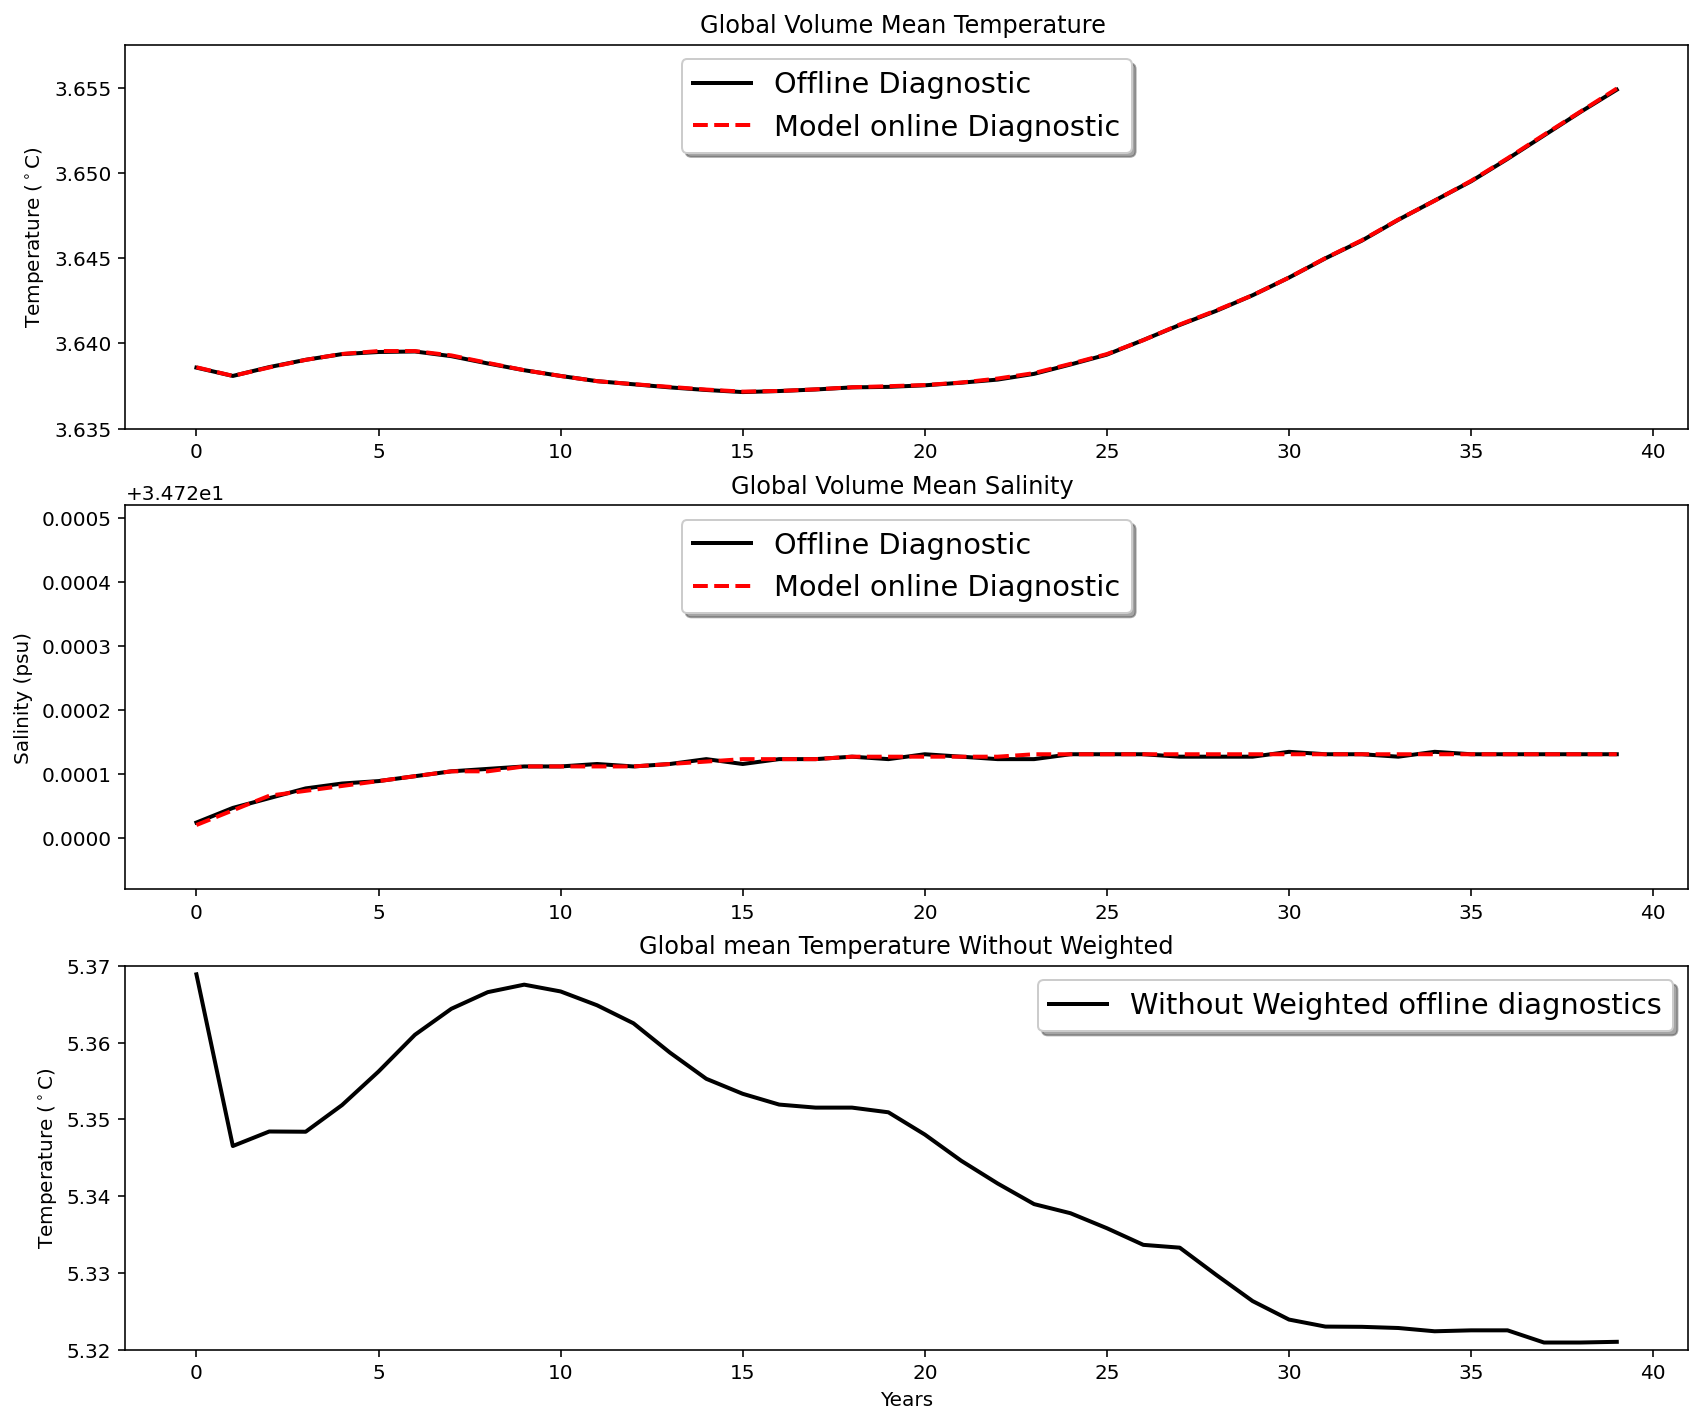

In [11]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(3, 1, 1)
ax.plot(temp_global_volume_ave_celsius, 'k',linewidth=2, label='Offline Diagnostic')
ax.plot(temp_global_ave, 'r--', linewidth=2, label='Model online Diagnostic')
plt.ylim(3.6350, 3.6575)
#plt.xlabel('Years')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Global Volume Mean Temperature ')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')
ax = fig.add_subplot(3, 1, 2)
ax.plot(salt_global_volume_ave, 'k', linewidth=2,label='Offline Diagnostic')
ax.plot(salt_global_ave,'r--',linewidth=2, label='Model online Diagnostic')
plt.ylim(34.71992, 34.72052)
#plt.xlabel('Years')
plt.ylabel('Salinity (psu)')
plt.title('Global Volume Mean Salinity ')

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

ax = fig.add_subplot(3, 1, 3)
ax.plot(global_temp_deg,'k',linewidth=2, label='Without Weighted offline diagnostics')
plt.ylim(5.32, 5.37)
plt.xlabel('Years')
plt.ylabel('Temperature ($^\circ$C)')
plt.title('Global mean Temperature Without Weighted')
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large');